In [ ]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

from data_processing import DataLoader
from modeling import Modeling

#### Load Processed Fraud Data

In [2]:
loader = DataLoader("../data/processed/fraud_data_features.csv")
df = loader.load_data()

df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,ip_int,hour_of_day,...,country_Unknown,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,-0.160204,QVPSPJUOCKZAR,39,7.327584e+08,0,732758368,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,-1.142592,EOGFQPIZPYXFZ,53,3.503114e+08,0,350311387,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,-1.197169,YSSKYOSJHPPLJ,53,2.621474e+09,1,2621473820,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,0.385567,ATGTXKYKUDUQN,41,3.840542e+09,0,3840542443,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,0.112681,NAUITBZFJKHWW,45,4.155831e+08,0,415583117,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data Preparation

In [3]:
# Define columns to drop from features
DROP_COLS = [
    "class",
    "purchase_time",
    "signup_time",
    "user_id",
    "device_id",
    "ip_address"
]

# Prepare features (X) and target (y)
X = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
y = df["class"]

print("Fraud rate:", y.mean())

Fraud rate: 0.09364577267192546


Initialize fraud modeling

In [4]:
fraud_model = FraudModeling()

### Stratified train-test split

In [5]:
fraud_model.prepare_data(X, y)

X_train, X_test = fraud_model.X_train, fraud_model.X_test
y_train, y_test = fraud_model.y_train, fraud_model.y_test

### Baseline Model – Logistic Regression

In [6]:
print("Training Logistic Regression baseline...")
log_res_df = fraud_model.train_logistic_baseline()
display(log_res_df.drop(columns=["Confusion Matrix"]))

Training Logistic Regression baseline...


,Model,AUC-PR,F1,Precision,Recall,Best Threshold
0,Logistic Regression,0.662557,0.667708,0.906118,0.528622,0.873


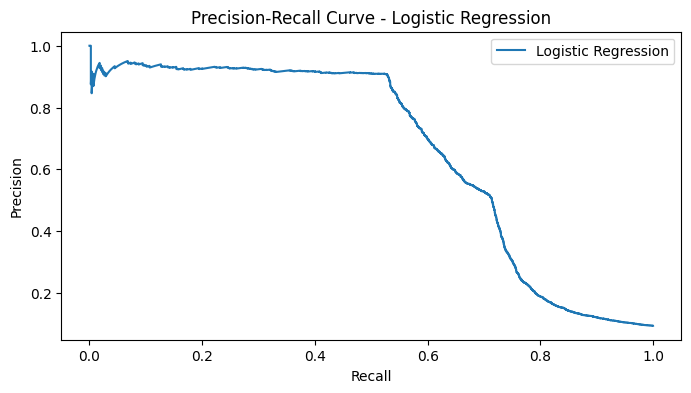

In [21]:
# PR curve for Logistic Regression
probs = fraud_model.models["Logistic Regression"].predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

plt.figure(figsize=(8,4))
plt.plot(recall, precision, label="Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend()
plt.show()


### Ensemble Model – Random Forest with Hyperparameter Tuning

In [8]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10, None]
}

print("\nTraining Random Forest with hyperparameter tuning...")
rf_res_df = fraud_model.train_random_forest(param_grid)

display(rf_res_df.drop(columns=["Confusion Matrix"]))



Training Random Forest with hyperparameter tuning...


,Model,AUC-PR,F1,Precision,Recall,Best Threshold
0,Random Forest,0.70884,0.690564,0.999331,0.527562,0.605


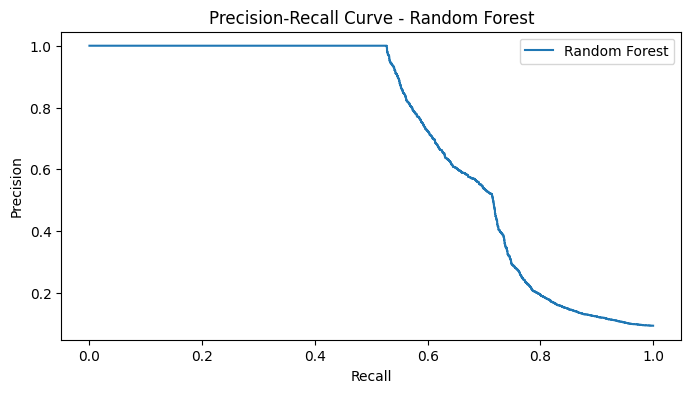

In [20]:
# PR curve
probs_rf = fraud_model.models["Random Forest"].predict_proba(X_test)[:, 1]
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, probs_rf)

plt.figure(figsize=(8,4))
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend()
plt.show()


### Cross-Validation

In [13]:
cv_results = []

for model_name in fraud_model.models:
    mean_auc, std_auc = fraud_model.cross_validated_auc_pr(model_name, X, y)
    cv_results.append({
        "Model": model_name,
        "CV AUC-PR Mean": mean_auc,
        "CV AUC-PR Std": std_auc
    })

cv_results_df = pd.DataFrame(cv_results)
display(cv_results_df)


,Model,CV AUC-PR Mean,CV AUC-PR Std
0,Logistic Regression,0.670758,0.008258
1,Random Forest,0.714049,0.006769


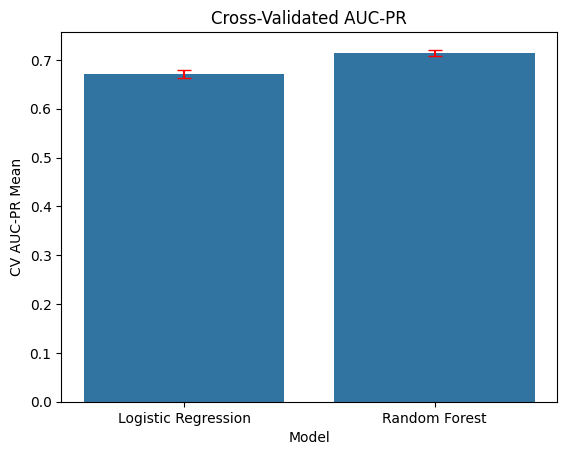

In [14]:
sns.barplot(x="Model", y="CV AUC-PR Mean", data=cv_results_df)
plt.errorbar(x=range(len(cv_results_df)), 
             y=cv_results_df["CV AUC-PR Mean"], 
             yerr=cv_results_df["CV AUC-PR Std"], 
             fmt='none', c='red', capsize=5)
plt.title("Cross-Validated AUC-PR")
plt.show()


### Model Comparison 

In [15]:
comparison_df = fraud_model.compare_models()

# Optional: drop the confusion matrix column for cleaner display
display(comparison_df.drop(columns=["Confusion Matrix"]))


,Model,AUC-PR,F1,Precision,Recall,Best Threshold
0,Random Forest,0.708840,0.690564,0.999331,0.527562,0.605
1,Logistic Regression,0.662557,0.667708,0.906118,0.528622,0.873


### Best Model Selection

In [16]:
best_model = comparison_df.iloc[0]
print("\nSelected Best Model:")
display(best_model)


Selected Best Model:


Model                            Random Forest
AUC-PR                                 0.70884
F1                                    0.690564
Precision                             0.999331
Recall                                0.527562
Best Threshold                           0.605
Confusion Matrix    [[27392, 1], [1337, 1493]]
Name: 0, dtype: object

### Final Model Selection & Justification

After comparing the Logistic Regression (Baseline) and the Random Forest (Ensemble), Random Forest is selected as the final model for deployment. 

**Rationale**
- **Performance:** The Random Forest outperformed the baseline with an AUC-PR of 0.71 (vs. 0.66). In fraud detection, where the "Fraud" class is the minority, AUC-PR is the most critical metric as it demonstrates the model's ability to maintain high precision while maximizing the capture of fraudulent transactions.

- **Stability and Reliability:** Cross-validation results (Mean AUC-PR: 0.714, Std: 0.006) confirm that the Random Forest is highly stable and less likely to overfit to specific transaction windows or user groups.

- **Business Value:** While the Random Forest is computationally more intensive than a linear model, the gain in precision (99.9% at the best threshold) significantly reduces "Customer Friction"—ensuring that legitimate users are almost never blocked, which is vital for maintaining e-commerce revenue and brand trust.